In [1]:
import numpy as np
import scipy
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# Homework 2
## Hypothesis testing

Each task is worth 5 points. Additionally, some tasks allow you to get a bonus point, that **can not** increase your total score for the homework beyond the maximum, but can compensate for some occasionally lost points.

### Task 1: multiple comparisons (Wasserman, exercise 10.11)

A randomized, double-blind experiment was conducted to assess the
effectiveness of several drugs for reducing postoperative nausea. The
data are as follows:

In [2]:
df = pd.DataFrame({'Drug': ['Placebo', 'Chlorpromazine', 'Dimenhydrinate', 'Pentobarbital (100 mg)', 'Pentobarbital (150 mg)'],
                    'Number of Patients': [80, 75, 85, 67, 85],
                    'Incidence of Nausea': [45, 26, 52, 35, 37]})
df

,Drug,Number of Patients,Incidence of Nausea
0,Placebo,80,45
1,Chlorpromazine,75,26
2,Dimenhydrinate,85,52
3,Pentobarbital (100 mg),67,35
4,Pentobarbital (150 mg),85,37


1. Test each drug versus the placebo at the 5% level. Also, report
the estimated odds–ratios. Summarize your findings. (2 points)
2. Use the Bonferroni and the FDR method to adjust for multiple
testing. (Beecher (1959)) (3 points)
3. Reproduce plot similar to Figure 10.6 from the book, displaying observed $p$-values and different thresholds used (1 bonus point)

*Hint*. Use simple $H_0$: "$p_{drug} = p_{placebo}$".

1. Test each drug versus the placebo at the 5% level. Also, report
the estimated odds–ratios. Summarize your findings. (2 points)

It's convenient to use a Wald criterion here.

In [3]:
alpha = 0.05

# H_0:
placebo_number = df.iloc[0:1].values[0][1]
placebo_inc = df.iloc[0:1].values[0][2]
hypothesis_mean = placebo_inc / placebo_number

odd_ratios = []
pvalues_ttest = []
wald_vals = []
p_values = []

for i in range(1, len(df)):
    numb, incid = df.iloc[i:i+1].values[0][1:]
    curr_mean = incid / numb
    
    # As it is considered as a Bernoulli distribution, its sample variance is
    # represented like pn = p(1-p):
    curr_SE = np.sqrt(curr_mean * (1 - curr_mean) / numb \
                      + hypothesis_mean * (1 - hypothesis_mean) / placebo_number)
    
    curr_delta = curr_mean - hypothesis_mean
    wald_vals.append(abs(curr_delta / curr_SE))
    
    odd_ratios.append((incid / (numb - incid)) / (placebo_inc / (placebo_number - placebo_inc)))
    
    p_value = 2 * (1 - sps.norm.cdf(wald_vals[i-1]))
    p_values.append(p_value)
    
    if  wald_vals[i-1] > sps.norm.ppf(1 - alpha / 2):
        print(f"Seems, that {df.Drug.values[i]} really works.")
        print(f"Its odd ratio is: {odd_ratios[i-1]}.")
    else:
        print(f"Seems, that {df.Drug.values[i]} does not really work.")
        print(f"Its odd ratio is: {odd_ratios[i-1]}.")
    print("\n")

Seems, that Chlorpromazine really works.
Its odd ratio is: 0.4126984126984127.


Seems, that Dimenhydrinate does not really work.
Its odd ratio is: 1.2255892255892253.


Seems, that Pentobarbital (100 mg) does not really work.
Its odd ratio is: 0.8506944444444444.


Seems, that Pentobarbital (150 mg) does not really work.
Its odd ratio is: 0.599537037037037.




So, due to the Wald's test, the only working drug is Chlorpromazine.

2. Use the Bonferroni and the FDR method to adjust for multiple
testing. (Beecher (1959)) (3 points)

In [4]:
method = "bonferroni" 

reject, bonferr_p, _, _ = multipletests(p_values, method=method, returnsorted=True)
print(f"Method {method:10s}: reject=\n{reject}\n with p-values = \n{bonferr_p}, \n")
    
method = "fdr_bh"
reject, fdr_p, _, _ = multipletests(p_values, method=method, returnsorted=True)
print(f"Method {method:10s}: reject=\n{reject}\n with p-values = \n{fdr_p}, \n")    

Method bonferroni: reject=
[ True False False False]
 with p-values = 
[0.02281357 0.39855693 1.         1.        ], 

Method fdr_bh    : reject=
[ True False False False]
 with p-values = 
[0.02281357 0.19927847 0.62666409 0.62666409], 



3. Reproduce plot similar to Figure 10.6 from the book, displaying observed $p$-values and different thresholds used (1 bonus point)

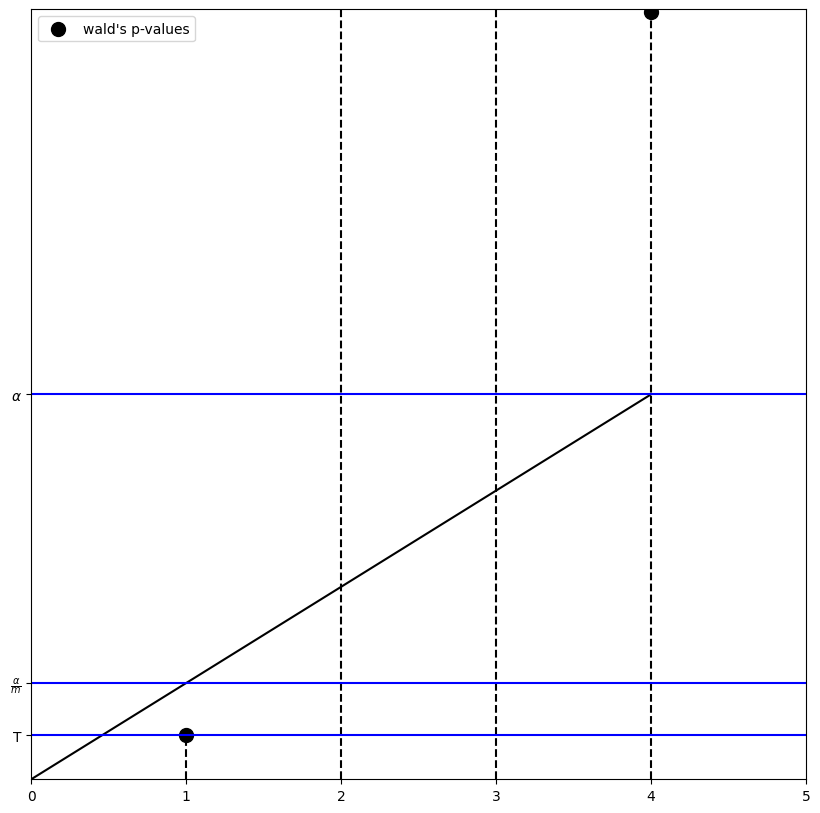

In [5]:
plt.figure(figsize=(10, 10))

m = df[1:].shape[0]

plots = [p_values, bonferr_p, fdr_p]

plt.scatter(np.arange(1, 5, 1), plots[0], c='k', s=100, label='wald\'s p-values')
for i, j in zip(range(1, 5), plots[0]):
    plt.plot((i, i), (0, j), 'k--')

x = np.arange(0, 5, 1)
y = alpha * x / m
plt.plot(x, y, color="black")

y_ticks = [alpha, alpha / m, p_values[0]]
y = plt.gca().set_yticks(y_ticks)

plt.hlines(y_ticks, color="blue", xmin=0, xmax=5)

labels = plt.gca().get_yticks().tolist()
labels = [r"$\alpha$", r"$\frac{\alpha}{m}$", "T"]
plt.gca().set_yticklabels(labels)

plt.ylim(0, alpha + 0.05)
plt.xlim(0, 5)
plt.legend()
plt.show()

### Task 2: permutation test

For this task we will use the famous Iris dataset, originaly studied by R.A. Fisher himself.

In [6]:
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We will select two species: *setosa* and *virginica* and study the sepal length.

In [7]:
X = iris[iris.species == 'setosa']['sepal_width'].values
Y = iris[iris.species == 'virginica']['sepal_width'].values

Test the hypothesis $H_0$: "quantiles of level 0.25 of both flowers are equal" vs $H_1$: "quantile of level 0.25 (25 percentile, lower 25%) of the sepal width of *setosa* flowers is  larger than that of *virginica* flowers". Use permutation test, approximate the full permutation distribution with 10,000 samples. (5 points)


In [8]:
# A self-written function:
import random

N = 10000 # the number of samples


def permutation_test(X, Y, N):
    list_x = X.tolist()
    list_y = Y.tolist()
    list = list_x + list_y
    diffs = []
    
    for i in range(N):
        random.shuffle(list)
        diffs.append(np.quantile(a=list[:50], q=0.25) - np.quantile(a=list[50:], q=0.25))

    k = 0
    for i in range(N):
        if diffs[i] >= 0:
            k += 1

    return diffs, k / N

perm_list, perm_val = permutation_test(X, Y, N)

print(f"P-value in that case is equal to {perm_val}.")

P-value in that case is equal to 0.6885.


In [9]:
# A library function:

N = 10000 # the number the of samples

def statistic(x, y):
    list = x+y
    return np.quantile(a=list, q=0.25) # quantile of level 0.25

result = sps.permutation_test((X, Y), statistic=statistic, n_resamples=N, alternative="less")

p_value = result.pvalue
print(f"P-value in that case is equal to {p_value}.")

P-value in that case is equal to 0.6442355764423557.


As the p-value is large, the $H_0$ hypothesis holds.

### Task 3: computational approach to hypothesis testing

Recommended reading: http://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html

Consider the following dataset (service hours between failures of the air-conditioning equipment in a Boeing 720 jet aircraft , Proschan, 1963):

In [10]:
Y = np.array([3, 5, 7, 18, 43, 85, 91, 98, 100, 130, 230, 487])

This sample was sorted for easier presentation.

1. Compute an estimate of the median time between failures (1 point)
2. Consider the null hypothesis $H_0$ to be: "median time between failures is one week" (1 point)
3. What distribution will you choose for this kind of data under $H_0$? (1 point)
4. Choose a statistic to measure the deviation from $H_0$ (effect size) (1 point)
5. Check whether you can reject $H_0$ at significance level 5% and calculate the corresponding approximate $p$-value. Use 10,000 simulations for your experiment (1 point)
6. Plot histogram of simulated effect sizes and mark the observed effect size (1 bouns point)

### Subtask 1.

(array([5., 3., 2., 0., 1., 0., 0., 0., 0., 1.]),
 array([  3. ,  51.4,  99.8, 148.2, 196.6, 245. , 293.4, 341.8, 390.2,
        438.6, 487. ]),
 <BarContainer object of 10 artists>)

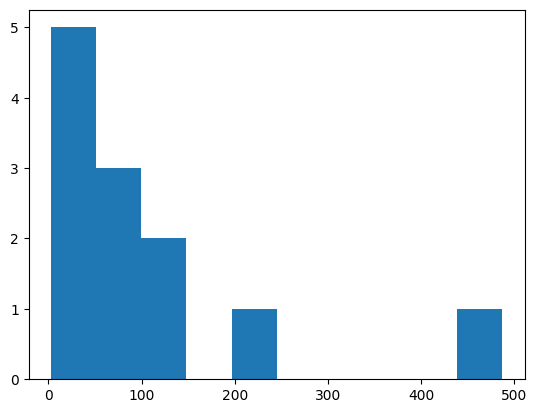

In [11]:
plt.hist(Y)

As the distribution of the parameter looks like Exponential distribution, the right way to estimate the median is to use the following formula: $$\hat{mean} = \frac{1}{\hat{\lambda}} = \
\frac{\sum^n_{i=1}x_i}{n}$$

$$\hat{median} = \frac{ln2}{\hat{\lambda}} = \hat{mean}*ln2 $$

In [12]:
median = np.log(2) * np.mean(Y)
print(f"The estimate of the median between failures is equal to: {median}.")

The estimate of the median between failures is equal to: 74.91765776552074.


### Subtask 2.

In [13]:
null_hypothesis = 24 * 7 # 24 hours * 7 days to obtain the quantity of hours:
print(f"The considered null hypothesis is equal to: {null_hypothesis}.")

The considered null hypothesis is equal to: 168.


### Subtask 3.

The plot looks like the Exponential distribution:

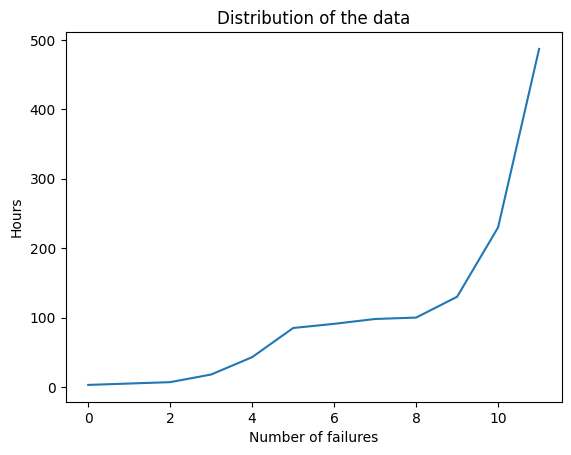

In [14]:
plt.plot(Y)
plt.title("Distribution of the data")
plt.xlabel("Number of failures")
plt.ylabel("Hours")
plt.show()

### Subtask 4.

It seems, that it is nice to use Wald's criterion.

$$W_n = \frac{\hat{\theta}_n - \theta_0}{\hat{se}} \rightsquigarrow N(0,1), n \rightarrow \inf$$

### Subtask 5.

In [15]:
N = 10000 # the number of simulations
alpha = 0.05

est_lambda = np.log(2) / null_hypothesis
sample_medians = []

for i in range(N):
    sample = sps.expon.rvs(scale=1 / est_lambda, size=len(Y))
    sample_medians.append(np.median(sample))

se = np.std(sample_medians)
wald_val = abs((median - null_hypothesis) / se)
p_value = 2 * (1 - sps.norm.cdf(abs(wald_val)))
print(f"The p-value in that case is equal to: {p_value}.")

The p-value in that case is equal to: 0.17330285225467756.


Due to the p-value, there is no need to reject the $H_0$.

### Subtask 6.

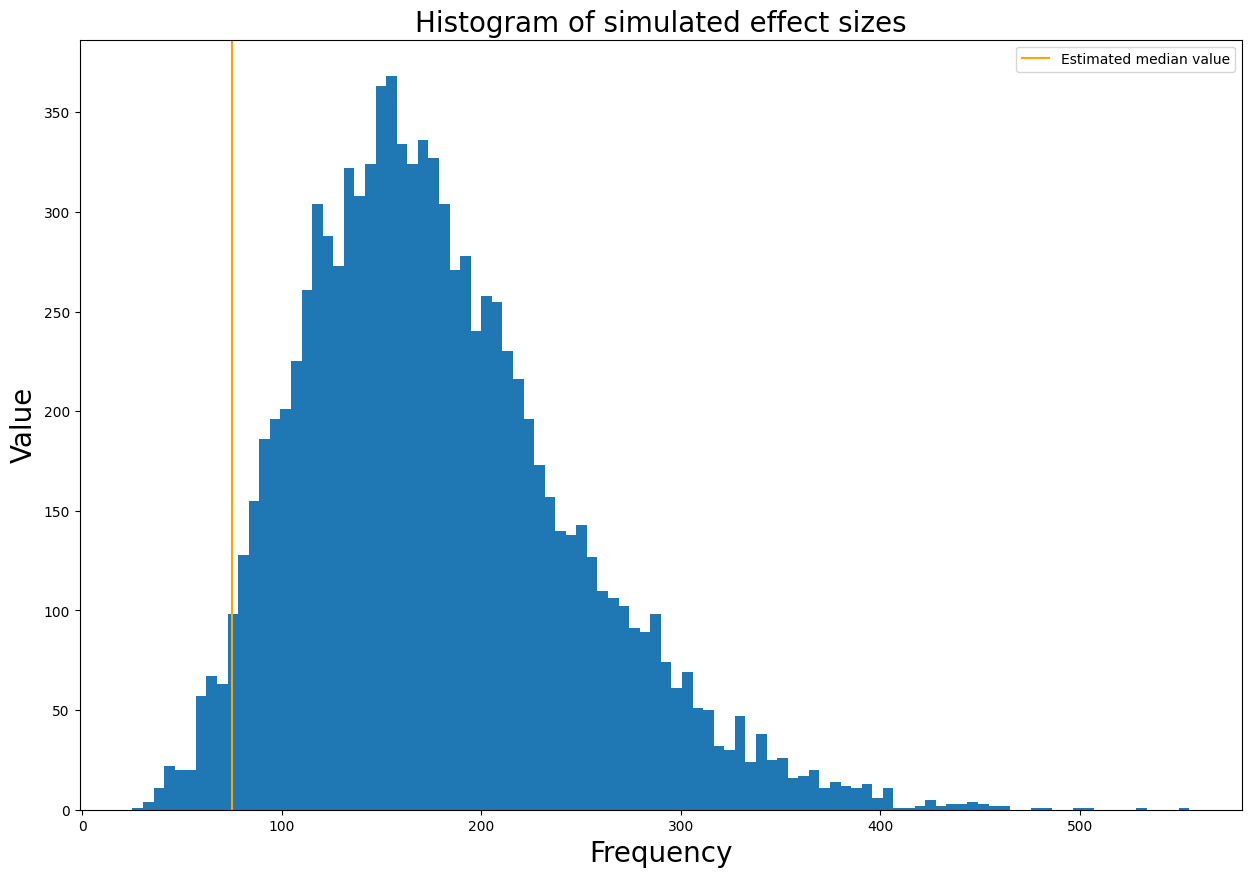

In [16]:
plt.figure(figsize=(15, 10))

plt.hist(sample_medians, bins=100)
plt.title('Histogram of simulated effect sizes', fontsize=20)

plt.axvline(median, 0, 1, color='orange', label="Estimated median value")

plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Value', fontsize=20)

plt.legend()
plt.show()

The plot confirms the conclusion above.

### Task 4. Power analysis .Bonus. 

In 1861, 10 essays appeared in the New Orleans Daily Crescent. They
were signed “Quintus Curtius Snodgrass” and some people suspected
they were actually written by Mark Twain. To investigate this, we will
consider the proportion of three letter words found in an author’s work.
From eight Twain essays we have:

In [17]:
X = np.array([.225, .262, .217, .240, .230, .229, .235, .217])

From 10 Snodgrass essays we have:

In [18]:
Y = np.array([.209, .205, .196, .210, .202, .207, .224, .223, .220, .201])

1. Perform a Wald test for equality of the means. Use the nonparametric plug-in estimator. Report the $p$-value and a 95% confidence
interval for the difference of means. What do you conclude? (1.5 points)
2. Now use a permutation test to avoid the use of large sample methods.
What is your conclusion? (Brinegar (1963)) (1.5 points)
3. Assume that samples do indeed come from different populations. Additionally, observed sample means and variaces for the two samples are equal to the true values for the respective population. Estimate the power of the two tests above under two model distributions for the data: Normal and [Beta](https://en.wikipedia.org/wiki/Beta_distribution) (use the same family for both samples) (2 points)

(array([2., 1., 2., 1., 0., 1., 0., 0., 0., 1.]),
 array([0.217 , 0.2215, 0.226 , 0.2305, 0.235 , 0.2395, 0.244 , 0.2485,
        0.253 , 0.2575, 0.262 ]),
 <BarContainer object of 10 artists>)

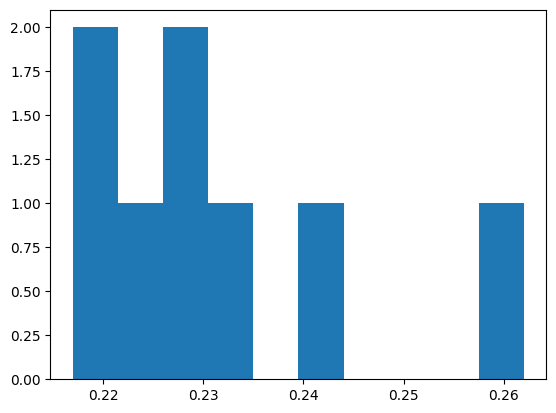

In [19]:
plt.hist(X)

(array([1., 1., 1., 2., 2., 0., 0., 0., 1., 2.]),
 array([0.196 , 0.1988, 0.2016, 0.2044, 0.2072, 0.21  , 0.2128, 0.2156,
        0.2184, 0.2212, 0.224 ]),
 <BarContainer object of 10 artists>)

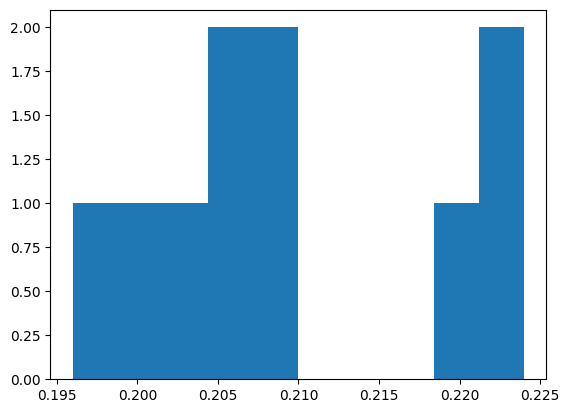

In [20]:
plt.hist(Y)

### Subtask 1

In [21]:
def estimation(X, Y, alpha): # X and Y are samples:
    x_mean = np.mean(X)
    y_mean = np.mean(Y)
    
    x_var = np.var(X, ddof=1)
    y_var = np.var(Y, ddof=1)
    
    se = np.sqrt(x_var / len(X) + y_var / len(Y))

    wald = (x_mean - y_mean) / se
    
    p_value = 2 * (1 - sps.norm.cdf(wald))
    z = sps.norm.ppf(1 - alpha / 2)

    return (wald > z), p_value, [wald - se * z, wald + se * z]

In [22]:
alpha = 0.05
verdict, p, conf_int = estimation(X, Y, alpha)
if verdict == True:
    print("We reject the H_0 hypothesis because due to the Wald's test that text unlikely belongs to Mark Twain.")
    print(f"Its p-value equals to: {p}.")
    print(f"The {alpha} confidence interval is: {conf_int}.")
    

else:
    print("We accept the H_0 hypothesis because due to the Wald's test that text likely belongs to Mark Twain.")
    print(f"Its p-value equals to: {p}.")
    print(f"The {alpha} confidence interval is: {conf_int}.")


We reject the H_0 hypothesis because due to the Wald's test that text unlikely belongs to Mark Twain.
Its p-value equals to: 0.00021260028225800198.
The 0.05 confidence interval is: [3.691818274183975, 3.715288814483666].


### Subtask 2

In [23]:
N = 10000 # the number of samples

def statistic(x, y):
    return np.mean(x) - np.mean(y)

result = sps.permutation_test((X, Y), statistic=statistic, n_resamples=N, alternative='greater')

p_value = result.pvalue
print(f"P-value in that case is equal to {p_value}.")


P-value in that case is equal to 0.0007999200079992001.


P-value is really small ($\approx$ [0.0004, 0.0007]), so the $H_0$ is rejected again. However, that method is better for small samples, so it is possible to consider, that that P-value is more accurate.